<a href="https://colab.research.google.com/github/iuliastremciuc/DS-Unit-2-Linear-Models/blob/master/module4-logistic-regression/IS_214_LS_DS_214_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 1, Module 4*

---

# Logistic Regression


## Assignment 🌯

You'll use a [**dataset of 400+ burrito reviews**](https://srcole.github.io/100burritos/). How accurately can you predict whether a burrito is rated 'Great'?

> We have developed a 10-dimensional system for rating the burritos in San Diego. ... Generate models for what makes a burrito great and investigate correlations in its dimensions.

- [ ] Do train/validate/test split. Train on reviews from 2016 & earlier. Validate on 2017. Test on 2018 & later.
- [ ] Begin with baselines for classification.
- [ ] Use scikit-learn for logistic regression.
- [ ] Get your model's validation accuracy. (Multiple times if you try multiple iterations.)
- [ ] Get your model's test accuracy. (One time, at the end.)
- [ ] Commit your notebook to your fork of the GitHub repo.


## Stretch Goals

- [ ] Add your own stretch goal(s) !
- [ ] Make exploratory visualizations.
- [ ] Do one-hot encoding.
- [ ] Do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html).
- [ ] Get and plot your coefficients.
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html).

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Linear-Models/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [0]:
# Load data downloaded from https://srcole.github.io/100burritos/
import pandas as pd
df = pd.read_csv(DATA_PATH+'burritos/burritos.csv')

In [0]:
# Derive binary classification target:
# We define a 'Great' burrito as having an
# overall rating of 4 or higher, on a 5 point scale.
# Drop unrated burritos.
df = df.dropna(subset=['overall'])
df['Great'] = df['overall'] >= 4

In [0]:
# Clean/combine the Burrito categories
df['Burrito'] = df['Burrito'].str.lower()

california = df['Burrito'].str.contains('california')
asada = df['Burrito'].str.contains('asada')
surf = df['Burrito'].str.contains('surf')
carnitas = df['Burrito'].str.contains('carnitas')

df.loc[california, 'Burrito'] = 'California'
df.loc[asada, 'Burrito'] = 'Asada'
df.loc[surf, 'Burrito'] = 'Surf & Turf'
df.loc[carnitas, 'Burrito'] = 'Carnitas'
df.loc[~california & ~asada & ~surf & ~carnitas, 'Burrito'] = 'Other'

In [0]:
# Drop some high cardinality categoricals
df = df.drop(columns=['Notes', 'Location', 'Reviewer', 'Address', 'URL', 'Neighborhood'])

In [0]:
# Drop some columns to prevent "leakage"
df = df.drop(columns=['Rec', 'overall'])

In [0]:
df.head()

,Burrito,Date,Yelp,Google,Chips,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Unreliable,NonSD,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Queso,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini,Great
0,California,1/18/2016,3.5,4.2,NaN,6.49,3.0,NaN,NaN,NaN,NaN,NaN,3.0,5.0,3.0,3.5,4.0,4.0,4.0,4.0,4.0,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1,California,1/24/2016,3.5,3.3,NaN,5.45,3.5,NaN,NaN,NaN,NaN,NaN,2.0,3.5,2.5,2.5,2.0,4.0,3.5,2.5,5.0,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2,Carnitas,1/24/2016,NaN,NaN,NaN,4.85,1.5,NaN,NaN,NaN,NaN,NaN,3.0,2.0,2.5,3.0,4.5,4.0,3.0,3.0,5.0,NaN,NaN,NaN,x,x,NaN,NaN,NaN,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
3,Asada,1/24/2016,NaN,NaN,NaN,5.25,2.0,NaN,NaN,NaN,NaN,NaN,3.0,2.0,3.5,3.0,4.0,5.0,4.0,4.0,5.0,NaN,NaN,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
4,California,1/27/2016,4.0,3.8,x,6.59,4.0,NaN,NaN,NaN,NaN,NaN,4.0,5.0,4.0,3.5,4.5,5.0,2.5,4.5,4.0,NaN,NaN,x,x,NaN,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True


In [0]:
df.isnull().sum()

Burrito             0
Date                0
Yelp              334
Google            334
Chips             395
Cost                7
Hunger              3
Mass (g)          399
Density (g/mL)    399
Length            138
Circum            140
Volume            140
Tortilla            0
Temp               20
Meat               14
Fillings            3
Meat:filling        9
Uniformity          2
Salsa              25
Synergy             2
Wrap                3
Unreliable        388
NonSD             414
Beef              242
Pico              263
Guac              267
Cheese            262
Fries             294
Sour cream        329
Pork              370
Chicken           400
Shrimp            400
Fish              415
Rice              385
Beans             386
Lettuce           410
Tomato            414
Bell peper        414
Carrots           420
Cabbage           413
Sauce             383
Salsa.1           414
Cilantro          406
Onion             404
Taquito           417
Pineapple 

In [0]:
df.shape

(421, 59)

In [0]:
df.describe(include = 'all')

,Burrito,Date,Yelp,Google,Chips,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Unreliable,NonSD,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Queso,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini,Great
count,421,421,87.000000,87.000000,26,414.000000,418.000000,22.000000,22.000000,283.000000,281.000000,281.000000,421.000000,401.000000,407.000000,418.000000,412.000000,419.000000,396.000000,419.000000,418.000000,33,7,179,158,154,159,127,92,51,21,21,6,36,35,11,7,7,1,8,38,7,15,17,4,7,2,4,4,1,0.0,5,3,3,2,13,3,1,421
unique,5,169,NaN,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1,2,2,2,2,2,2,2,1,1,1,1,NaN,1,1,1,1,1,2,1,2
top,California,8/30/2016,NaN,NaN,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,NaN,x,x,x,x,x,x,x,False
freq,169,29,NaN,NaN,21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33,5,137,127,114,128,102,67,36,20,17,4,26,27,9,5,4,1,6,33,6,9,9,3,5,2,4,4,1,NaN,5,3,3,2,13,2,1,239
mean,NaN,NaN,3.887356,4.167816,NaN,7.067343,3.495335,546.181818,0.675277,20.038233,22.135765,0.786477,3.519477,3.783042,3.620393,3.539833,3.586481,3.428998,3.371970,3.586993,3.979904,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,0.475396,0.373698,NaN,1.506742,0.812069,144.445619,0.080468,2.083518,1.779408,0.152531,0.794438,0.980338,0.829254,0.799549,0.997057,1.068794,0.924037,0.886807,1.118185,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,2.500000,2.900000,NaN,2.990000,0.500000,350.000000,0.560000,15.000000,17.000000,0.400000,1.000000,1.000000,1.000000,1.000000,0.500000,0.000000,0.000000,1.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,3.500000,4.000000,NaN,6.250000,3.000000,450.000000,0.619485,18.500000,21.000000,0.680000,3.000000,3.000000,3.000000,3.000000,3.000000,2.600000,3.000000,3.000000,3.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,4.000000,4.200000,NaN,6.990000,3.500000,540.000000,0.658099,20.000000,22.000000,0.770000,3.500000,4.000000,3.800000,3.500000,4.000000,3.500000,3.500000,3.800000,4.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,4.000000,4.400000,NaN,7.880000,4.000000,595.000000,0.721726,21.500000,23.000000,0.880000,4.000000,4.500000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,5.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
df.nunique()

Burrito             5
Date              169
Yelp                6
Google             18
Chips               4
Cost               98
Hunger             25
Mass (g)           18
Density (g/mL)     21
Length             29
Circum             30
Volume             64
Tortilla           18
Temp               18
Meat               23
Fillings           22
Meat:filling       25
Uniformity         28
Salsa              27
Synergy            27
Wrap               23
Unreliable          1
NonSD               2
Beef                2
Pico                2
Guac                2
Cheese              2
Fries               2
Sour cream          2
Pork                2
Chicken             2
Shrimp              2
Fish                2
Rice                2
Beans               2
Lettuce             2
Tomato              2
Bell peper          2
Carrots             1
Cabbage             2
Sauce               2
Salsa.1             2
Cilantro            2
Onion               2
Taquito             2
Pineapple 

In [0]:
df.isnull().sum()

In [0]:
df = df[['Burrito', 'Date', 'Cost', 'Hunger', 'Length', 'Circum', 'Volume', 'Tortilla', 'Temp', 'Meat', 'Fillings', 'Meat:filling', 'Uniformity', 'Salsa', 'Synergy', 'Wrap', 'Great']]

In [0]:
df

,Burrito,Date,Cost,Hunger,Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Great
0,California,1/18/2016,6.49,3.0,NaN,NaN,NaN,3.0,5.0,3.0,3.5,4.0,4.0,4.0,4.0,4.0,False
1,California,1/24/2016,5.45,3.5,NaN,NaN,NaN,2.0,3.5,2.5,2.5,2.0,4.0,3.5,2.5,5.0,False
2,Carnitas,1/24/2016,4.85,1.5,NaN,NaN,NaN,3.0,2.0,2.5,3.0,4.5,4.0,3.0,3.0,5.0,False
3,Asada,1/24/2016,5.25,2.0,NaN,NaN,NaN,3.0,2.0,3.5,3.0,4.0,5.0,4.0,4.0,5.0,False
4,California,1/27/2016,6.59,4.0,NaN,NaN,NaN,4.0,5.0,4.0,3.5,4.5,5.0,2.5,4.5,4.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
418,Other,8/27/2019,6.00,1.0,17.0,20.5,0.57,5.0,4.0,3.5,NaN,4.0,4.0,2.0,2.0,5.0,False
419,Other,8/27/2019,6.00,4.0,19.0,26.0,1.02,4.0,5.0,NaN,3.5,4.0,4.0,5.0,4.0,3.0,True
420,California,8/27/2019,7.90,3.0,20.0,22.0,0.77,4.0,4.0,4.0,3.7,3.0,2.0,3.5,4.0,4.5,False
421,Other,8/27/2019,7.90,3.0,22.5,24.5,1.07,5.0,2.0,5.0,5.0,5.0,2.0,5.0,5.0,2.0,True


In [0]:
#df = df.drop(['Unreliable', 'Carrots', 'Ham', 'Chile relleno', 'Nopales', 'Lobster', 'Queso', 'Egg', 'Mushroom', 'Bacon', 'Sushi', 'Avocado', 'Zucchini'], axis = 1)

In [0]:
df.head()

,Burrito,Date,Cost,Hunger,Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Great
0,California,1/18/2016,6.49,3.0,NaN,NaN,NaN,3.0,5.0,3.0,3.5,4.0,4.0,4.0,4.0,4.0,False
1,California,1/24/2016,5.45,3.5,NaN,NaN,NaN,2.0,3.5,2.5,2.5,2.0,4.0,3.5,2.5,5.0,False
2,Carnitas,1/24/2016,4.85,1.5,NaN,NaN,NaN,3.0,2.0,2.5,3.0,4.5,4.0,3.0,3.0,5.0,False
3,Asada,1/24/2016,5.25,2.0,NaN,NaN,NaN,3.0,2.0,3.5,3.0,4.0,5.0,4.0,4.0,5.0,False
4,California,1/27/2016,6.59,4.0,NaN,NaN,NaN,4.0,5.0,4.0,3.5,4.5,5.0,2.5,4.5,4.0,True


In [0]:
df.shape

(421, 17)

In [0]:
# Do train/validate/test split. Train on reviews from 2016 & earlier. Validate on 2017. Test on 2018 & later

df['Date'] = pd.to_datetime(df['Date'], infer_datetime_format= True)
train = df[df['Date'].dt.year <= 2016]
val = df[df['Date'].dt.year == 2017]
test = df[df['Date'].dt.year >= 2018]


In [0]:
train.shape, val.shape, test.shape

((298, 17), (85, 17), (38, 17))

In [0]:
# Begin with baselines for classification
target = 'Great'
y_train = train[target]
y_train.value_counts(normalize = True)

False    0.590604
True     0.409396
Name: Great, dtype: float64

In [0]:
df.describe(exclude = 'number').T.sort_values(by = 'unique')

,count,unique,top,freq,first,last
Great,421,2,False,239,NaT,NaT
Burrito,421,5,California,169,NaT,NaT
Date,421,169,2016-08-30 00:00:00,29,2011-05-16,2026-04-25


In [0]:
# Use scikit-learn for logistic regression
high_unique_num = ['Date']
target = 'Great'
features = train.columns.drop([target] + high_unique_num)
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
              


In [0]:
X_train.shape, X_val.shape

((298, 15), (85, 15))

In [0]:
import category_encoders as ce 
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression


In [0]:
encoder = ce.OneHotEncoder(use_cat_names = True)
X_train_enc = encoder.fit_transform(X_train)
X_val_enc = encoder.transform(X_val)

In [0]:
X_train_enc

,Burrito_California,Burrito_Carnitas,Burrito_Asada,Burrito_Other,Burrito_Surf & Turf,Cost,Hunger,Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap
0,1,0,0,0,0,6.49,3.0,NaN,NaN,NaN,3.0,5.0,3.0,3.5,4.0,4.0,4.0,4.0,4.0
1,1,0,0,0,0,5.45,3.5,NaN,NaN,NaN,2.0,3.5,2.5,2.5,2.0,4.0,3.5,2.5,5.0
2,0,1,0,0,0,4.85,1.5,NaN,NaN,NaN,3.0,2.0,2.5,3.0,4.5,4.0,3.0,3.0,5.0
3,0,0,1,0,0,5.25,2.0,NaN,NaN,NaN,3.0,2.0,3.5,3.0,4.0,5.0,4.0,4.0,5.0
4,1,0,0,0,0,6.59,4.0,NaN,NaN,NaN,4.0,5.0,4.0,3.5,4.5,5.0,2.5,4.5,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
296,1,0,0,0,0,5.65,3.0,19.5,22.0,0.75,4.0,1.5,2.0,3.0,4.2,4.0,3.0,2.0,4.5
297,0,0,0,1,0,5.49,3.0,19.0,20.5,0.64,4.5,5.0,2.0,2.0,2.5,3.5,3.0,2.5,3.0
298,1,0,0,0,0,7.75,4.0,20.0,21.0,0.70,3.5,2.5,3.0,3.3,1.4,2.3,2.2,3.3,4.5
299,0,0,1,0,0,7.75,4.0,19.5,21.0,0.68,4.0,4.5,2.0,2.0,3.5,3.5,2.0,2.0,4.0


In [0]:
X_train_enc.shape

(298, 19)

In [0]:
imputer = SimpleImputer(strategy='mean')
X_train_imp = imputer.fit_transform(X_train_enc)
X_val_imp = imputer.transform(X_val_enc)

In [0]:
X_train_imp

array([[1.        , 0.        , 0.        , ..., 4.        , 4.        ,
        4.        ],
       [1.        , 0.        , 0.        , ..., 3.5       , 2.5       ,
        5.        ],
       [0.        , 1.        , 0.        , ..., 3.        , 3.        ,
        5.        ],
       ...,
       [1.        , 0.        , 0.        , ..., 2.2       , 3.3       ,
        4.5       ],
       [0.        , 0.        , 1.        , ..., 2.        , 2.        ,
        4.        ],
       [0.        , 0.        , 0.        , ..., 3.32464029, 3.8       ,
        2.        ]])

In [0]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imp)
X_val_scaled = scaler.transform(X_val_imp)
X_val_scaled

array([[ 1.23508045, -0.22202652, -0.36480111, ..., -1.94861062,
        -0.04380471,  0.46918257],
       [-0.80966385, -0.22202652, -0.36480111, ...,  0.9348337 ,
         0.22859433,  0.89967866],
       [-0.80966385, -0.22202652, -0.36480111, ...,  1.04162794,
         0.71891261,  0.89967866],
       ...,
       [-0.80966385, -0.22202652, -0.36480111, ...,  0.18727406,
         0.50099338, -1.6832979 ],
       [ 1.23508045, -0.22202652, -0.36480111, ...,  0.18727406,
         0.82787223,  0.46918257],
       [ 1.23508045, -0.22202652, -0.36480111, ...,  1.78918758,
         1.59058956, -0.82230572]])

In [0]:
log_reg = LogisticRegression()
log_reg.fit(X_train_scaled, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
log_reg.predict(X_val_scaled)

array([ True, False,  True,  True, False, False,  True,  True, False,
        True,  True, False, False, False,  True, False, False,  True,
        True,  True,  True,  True, False,  True,  True,  True,  True,
       False,  True,  True,  True, False, False,  True, False, False,
        True,  True, False,  True, False, False,  True,  True,  True,
        True, False, False,  True, False, False, False,  True,  True,
       False, False, False, False, False, False, False, False, False,
       False, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True, False, False, False,  True,  True,  True,  True,
        True, False,  True,  True])

In [0]:
from sklearn.metrics import accuracy_score

In [0]:
log_reg.score(X_val_scaled, y_val)

0.8

In [0]:
# Get your model's validation accuracy. (Multiple times if you try multiple iterations.)
from sklearn.metrics import accuracy_score
print(log_reg.score(X_train_scaled, y_train))
print(log_reg.score(X_val_scaled, y_val))


0.8859060402684564
0.8


In [0]:
# Get your model's test accuracy. (One time, at the end.)
X_test = test[features]
X_test_enc = encoder.transform(X_test)
X_test_imp = imputer.transform(X_test_enc)
X_test_scaled = scaler.transform(X_test_imp)
test_pred = log_reg.predict(X_test_scaled)

In [0]:
test_pred

array([ True,  True, False,  True, False, False,  True,  True,  True,
        True,  True, False,  True,  True,  True,  True,  True, False,
       False, False, False,  True, False,  True,  True, False, False,
        True,  True,  True, False,  True,  True, False,  True,  True,
        True,  True])

In [0]:
y_test = test[target]
log_reg.score(X_test_scaled, y_test)

0.7631578947368421

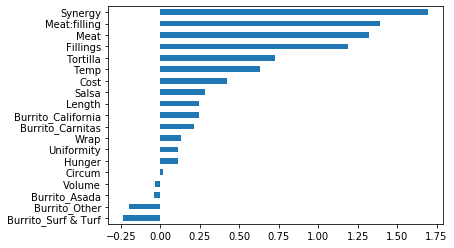

In [0]:
%matplotlib inline
coefficients = pd.Series(log_reg.coef_[0], X_train_enc.columns)
coefficients.sort_values().plot.barh();